# Fonctions pour le calcul avec le maximum de la vraisemblance

## Lecture et nettoyage des données (code fourni)

In [2]:
using CSV, DataFrames, Gadfly, Distributions, StatsBase, GaussianMixtures, IterTools

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\Mjk\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


In [3]:
train = CSV.read("ODtrain.csv")
n = size(train,1)
p = size(train,2)
dropmissing!(train, disallowmissing=true)
str_mode = ["Voiture", "Transport Collectif", "Hybride", "Actif", "Autre"]

d = Array{String}(undef,n)

for i=1:length(str_mode)
   
    ind = train[:D_Mode] .== i
    d[ind] .= str_mode[i] 
    
end

train[:D_Mode_str] = d

categorical!(train, :D_Mode_str);

## Analyse des distributions des données

Ici on peut changer les valeurs des trois premières variables pour tenter de trouver la bonne distribution à associer à une variable quelconque.

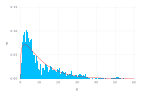

In [4]:
dep = 5;
sym = :M_dist_train
dist = Gamma

voi = train[train[:D_Mode] .== dep, :];
fd = fit_mle(dist, voi[sym]);
xx = 0:0.1:60;
f = pdf.(fd, xx);
h = layer(x = voi[sym], Geom.histogram(density = true));
f = layer(x = xx, y = f, Geom.line, Theme(default_color="red"));
plot(f, h)

## Fonctions pour le calcul

### Constante

In [5]:
k = 5

5

### Déclaration de types utilisés

In [6]:
struct MelangeNormales
    n::Int64
end

### Fonctions internes ("privées")

In [7]:
function determineMode(index::Int64, columns::Array{Symbol, 1}, testSet::DataFrame)
    # Y Cat(τ)
    τ = fit(Categorical, train[:D_Mode])
    # P(Y = i | X = dist) = p[i]
    p = Array{Float64}(undef, k)
    max = 1
    for i=1:k
        p[i] = log(pdf(τ, i))
        for varExp in columns
           p[i] += log(pdf(dist[varExp][i], testSet[varExp][index]))
        end
        if p[max] < p[i]
            max = i
        end
    end
    return max
end

function validate(estimates::Array{Int64}, realValue::Array{Int64})
    n = length(realValue)
    nEach = [0, 0, 0, 0, 0]
    right = [0, 0, 0, 0, 0]
    for i=1:n
        nEach[realValue[i]] += 1
        if estimates[i] == realValue[i]
            right[realValue[i]] += 1
        end
    end
    
    out = ""
    for i=1:k
        #print(str_mode[i], " : ", right[i]/nEach[i]*100, "%\n" ) 
        out *= str_mode[i] * " : " * string(right[i]/nEach[i]*100) * "%\n"
    end
    #print("Total : ", sum(right)/n*100, "%\n" )
    tot = sum(right)/n*100
    out *= "Total : " * string(tot) * "%\n"
    return (total=tot, output=out)
end

struct TestSet
    train::DataFrame
    test::DataFrame
end

function getTestSet(initialSet::DataFrame)
    n = length(initialSet[:D_Mode])
    nTest = convert(Int64, round(0.20 * n))
    index = rand(0:n-nTest+1)
    return TestSet(vcat(initialSet[1:index-1, :], initialSet[index+nTest:n, :]), initialSet[index:index+nTest-1, :])
    
    a = [1,2,3]
    b= view(a, 1:2)
    c= vcat(view(a, 1:1), view(a, 3:3))
end

function getEstimation(distType::Array{Any, 2}, columns::Array{Symbol, 1}, set::TestSet)
    # Maximum de la vraisemblance pour estimer
    nVariablesExpl = length(columns)
    for iVarExpl in 1:nVariablesExpl
        if !haskey(dist, columns[iVarExpl])
            dist[columns[iVarExpl]] = Array{Distribution}(undef, k)
            fitDistributions(distType[iVarExpl,:], columns[iVarExpl], set)
        end
    end
    amount = length(set.test[:IPERE])
    res= Array{Int64}(undef, amount)
    for i=1:amount
       res[i] = determineMode(i, columns, set.test) 
    end
    return res
end

function fitDistributions(distType::Array{Any, 1}, varExpl::Symbol, set::TestSet)
    for mode=1:k
        trainT = set.train[set.train[:D_Mode] .== mode, :];
        if typeof(distType[mode]) == MelangeNormales
            gmm = GMM(distType[mode].n, trainT[varExpl]; method=:kmeans, nInit=100, nIter=20)
            dist[varExpl][mode] = MixtureModel(gmm)
        else
             # fit_mle retourne les estimateurs avec le maximum de la vraisemblance.
            dist[varExpl][mode] = fit_mle(distType[mode], trainT[varExpl])
        end
    end
end

fitDistributions (generic function with 1 method)

### Fonction "publique"

In [8]:
function getPercentRight(distType::Array{Any, 2}, columns::Array{Symbol, 1})    
    set = getTestSet(train)
    estimation = getEstimation(distType, columns, set)
    print(validate(estimation, set.test[:D_Mode]).output)
end

#Evaluates all the models made from the combinations of up to $maxNVars variables contained in $columns and returns the best one
function getBestModel(maxNVars::Int64, distType::Array{Any, 2}, columns::Array{Symbol, 1})    
    #build the combinations of up to maxNVars
    subsetIndices = [] 
    for i in 1:maxNVars
        append!(subsetIndices, [j for j in subsets(1:length(columns), i)])
    end
    
    #generate the results for all models
    set = getTestSet(train)
    results = Array{NamedTuple}(undef, length(subsetIndices))
    for i in 1:length(subsetIndices)
        indices = subsetIndices[i]
        println("now testing: ", columns[indices])
        estimation = getEstimation(distType[indices, :], columns[indices], set)
        tot, out = validate(estimation, set.test[:D_Mode])
        results[i] = (total=tot, output=out, columns=columns[indices])
    end
    
    #rank models and return ranking
    sort!(results, by = x -> x.total, rev=true)
    print("Best model: ", results[1].columns, "\n", results[1].output)
    return results
end

function generateSubmission(distType::Array{Any, 2}, columns::Array{Symbol, 1})    
    test = CSV.read("ODtest.csv")
    submission = test[:, [:IPERE]]
    set = TestSet(train, test)
    estimation = getEstimation(distType, columns, set)
    submission = DataFrame(IPERE = test[:IPERE],D_MODE = estimation)
    CSV.write("Submission.csv", submission)
end

generateSubmission (generic function with 1 method)

### Exemple

Ici, on estime que la variable P_PERMIS est distribuée selon une loi Catégorielle.
On pense la même chose pour la variable P_STATUT.
Pour la variable M_dist_centre, on pense plutôt qu'elle suit une loi Gamma.

Pour les trois variables, nous avons donné la même distribution peut-importe la valeur de Y.
Cependant, si nous pensions que lorsque Y = 3, la variable M_dist_centre est distribuée selon une loi normale, nous aurions pu écrire:
Gamma Gamma Normal Gamma Gamma

Les fonctions ci-dessus séparent l'échantillon train en deux portions (4/5 train, 1/5 test). Cette séparation change à toutes les fois où l'algorithme est roulé.
Le résultat de l'appel à getPercentRight est séparé selon le mode de transport.

In [11]:
#reset global known distributions
#dist = Dict()

getPercentRight([
        [Categorical Categorical Categorical Categorical Categorical];
        [Categorical Categorical Categorical Categorical Categorical];
        [MelangeNormales(10) MelangeNormales(7) MelangeNormales(7) MelangeNormales(8) MelangeNormales(9)];
        [Poisson Poisson Poisson Poisson Poisson];
        ], [
        :P_PERMIS,
        :P_STATUT,
        :M_dist_centre,
        :M_AUTO
        ])

Voiture : 81.12582781456953%
Transport Collectif : 45.66353187042842%
Hybride : 0.0%
Actif : 30.350665054413543%
Autre : 77.05382436260622%
Total : 64.19464353074311%


In [42]:
#reset global known distributions
#dist = Dict()

generateSubmission([
        [Categorical Categorical Categorical Categorical Categorical];
        [Categorical Categorical Categorical Categorical Categorical];
        [MelangeNormales(10) MelangeNormales(7) MelangeNormales(7) MelangeNormales(8) MelangeNormales(9)];
        #[MelangeNormales(20) MelangeNormales(15) MelangeNormales(15) MelangeNormales(16) MelangeNormales(17)];
        [Poisson Poisson Poisson Poisson Poisson]
        ], [
        :P_PERMIS,
        :P_STATUT,
        :M_dist_centre,
        :M_AUTO
        ])

UndefRefError: UndefRefError: access to undefined reference

In [12]:
#reset global known distributions
#dist = Dict{Symbol, Array{Any}}()

getBestModel(4,
        [
            [Categorical Categorical Categorical Categorical Categorical];
            [Categorical Categorical Categorical Categorical Categorical];
            [MelangeNormales(10) MelangeNormales(7) MelangeNormales(7) MelangeNormales(8) MelangeNormales(9)];
            [Poisson Poisson Poisson Poisson Poisson];
        ], [
            :P_PERMIS,
            :P_STATUT,
            :M_dist_centre,
            :M_AUTO
        ])

now testing: Symbol[:P_PERMIS]
now testing: Symbol[:P_STATUT]
now testing: Symbol[:M_dist_centre]
now testing: Symbol[:M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT]
now testing: Symbol[:P_PERMIS, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :M_AUTO]
now testing: Symbol[:P_STATUT, :M_dist_centre]
now testing: Symbol[:P_STATUT, :M_AUTO]
now testing: Symbol[:M_dist_centre, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_dist_centre]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_AUTO]
now testing: Symbol[:P_PERMIS, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_STATUT, :M_dist_centre, :M_AUTO]
now testing: Symbol[:P_PERMIS, :P_STATUT, :M_dist_centre, :M_AUTO]
Best model: Symbol[:P_PERMIS, :P_STATUT, :M_dist_centre, :M_AUTO]
Voiture : 80.69546019042363%
Transport Collectif : 45.84214235377026%
Hybride : 0.0%
Actif : 25.04398826979472%
Autre : 78.65384615384615%
Total : 63.32704639758582%


15-element Array{NamedTuple,1}:
 (total = 63.32704639758582, output = "Voiture : 80.69546019042363%\nTransport Collectif : 45.84214235377026%\nHybride : 0.0%\nActif : 25.04398826979472%\nAutre : 78.65384615384615%\nTotal : 63.32704639758582%\n", columns = Symbol[:P_PERMIS, :P_STATUT, :M_dist_centre, :M_AUTO])
 (total = 63.04036212749906, output = "Voiture : 83.48282047743893%\nTransport Collectif : 47.674418604651166%\nHybride : 0.0%\nActif : 24.98533724340176%\nAutre : 50.67307692307692%\nTotal : 63.04036212749906%\n", columns = Symbol[:P_PERMIS, :M_dist_centre, :M_AUTO])          
 (total = 62.72350056582422, output = "Voiture : 83.89678487650062%\nTransport Collectif : 34.60183227625088%\nHybride : 0.0%\nActif : 25.923753665689148%\nAutre : 77.88461538461539%\nTotal : 62.72350056582422%\n", columns = Symbol[:P_PERMIS, :P_STATUT, :M_dist_centre])        
 (total = 61.561674839683135, output = "Voiture : 93.65254588105422%\nTransport Collectif : 32.100070472163495%\nHybride : 0.0%\nAc

In [45]:
dist

Dict{Symbol,Array{Any,N} where N} with 0 entries